# Imports

In [ ]:
%%shell
jupyter nbconvert --to html "/content/project03_CNN.ipynb"

[NbConvertApp] Converting notebook /content/project03_CNN.ipynb to html
[NbConvertApp] Writing 588827 bytes to /content/project03_CNN.html


In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()
import nltk
nltk.download("stopwords")
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
import pandas as pd
import numpy as np
import random
import re
import matplotlib.pyplot as plt

from nltk import word_tokenize, sent_tokenize
from gensim.models import Word2Vec, KeyedVectors

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split

from keras import Sequential, Model
from keras import layers
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.vis_utils import plot_model
from nltk.corpus import stopwords as STOPWORDS

stopWords = set(STOPWORDS.words('turkish'))

# Preparing Data

In [ ]:
folder_path = "/content/drive/MyDrive/CS 445 Project 3"

In [ ]:
def plotHistory(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

def preprocess(docs):
    result = []
    for d in docs:
        a = re.sub(r'[\'’\"”][\w]+ ', " " ,d)
        for stopword in stopWords:
            a = a.replace(" "+ stopword + " ", " ")
        a = re.sub(r'[“’‘\'\"”…]', "", a)
        a = re.sub(r'\d+', "", a)
        a = a.replace("  ", " ")
        result.append(a.lower())
    return result

In [ ]:
def read_data(path):
    data = pd.read_csv(path)
    return data

path = folder_path + "/dataset/train.csv"
data = read_data(path)

path = folder_path +  "/dataset/test.csv"
test_data = read_data(path)

In [ ]:
data_text = data["text"]
data_label = data["label"]

test_data_text = test_data["text"]
test_data_label = test_data["label"]

In [ ]:
class_mapping = {
    "turkiye": 0,
    "dunya": 1,
    "spor": 2,
    "video": 3,
    "yazarlar": 4,
}

In [ ]:
data_text[0]

"Beşiktaş'ın eski teknik direktörü Slaven Bilic, Türkiye-Hırvatistan maçında yorumculuk yapmak üzere Lig TV ile anlaştı.\nEURO 2016'nın yayıncı kuruluşlarından biri olan Lig TV, Türkiye'nin D Grubu'nda Hırvatistan ile oynayacağı ilk maç için Slaven Bilic ile anlaşıldığını duyurdu.\nBeşiktaş'ın eski teknik direktörü Slaven Bilic, 12 Haziran Pazar günü TSİ 16:00'da başlayacak mücadelede yorumcu olacak.\nLig TV, Slaven Bilic'in yanı sıra A Milli Takım'ın efsane kalecilerinden Rüştü Reçber'in de bu karşılaşmanın yorumcularından biri olacağını açıkladı.\nEURO 2008'de Hırvatistan'ın teknik direktörü olan Slaven Bilic, çeyrek finalde Türkiye'ye rakip olmuş ve 120 dakikası 1-1 biten maçta A Milli Takımımıza penaltılarda elenmişti."

In [ ]:
data_text = preprocess(data_text)
test_data_text = preprocess(test_data_text)

In [ ]:
data_text[0]

'beşiktaş eski teknik direktörü slaven bilic, türkiye-hırvatistan maçında yorumculuk yapmak üzere lig tv anlaştı.\neuro yayıncı kuruluşlarından olan lig tv, türkiye d grubu hırvatistan oynayacağı ilk maç slaven bilic anlaşıldığını duyurdu.\nbeşiktaş eski teknik direktörü slaven bilic, haziran pazar günü tsi̇ : başlayacak mücadelede yorumcu olacak.\nlig tv, slaven bilic yanı sıra a milli takım efsane kalecilerinden rüştü reçber karşılaşmanın yorumcularından olacağını açıkladı.\neuro hırvatistan teknik direktörü olan slaven bilic, çeyrek finalde türkiye rakip olmuş dakikası - biten maçta a milli takımımıza penaltılarda elenmişti.'

# Choose Pre-Trained Embedding

In [ ]:
EMBEDDING_DIM = 400

word_vectors = KeyedVectors.load_word2vec_format(folder_path + '/trmodel', binary=True)

In [ ]:
EMBEDDING_DIM = 300

word_vectors = KeyedVectors.load_word2vec_format(folder_path + "/CBOW_100k_300_10.txt", binary=False)

In [ ]:
EMBEDDING_DIM = 200

word_vectors = KeyedVectors.load_word2vec_format(folder_path + "/CBOW_100k_200_10.txt", binary=False)

In [ ]:
EMBEDDING_DIM = 100

word_vectors = KeyedVectors.load_word2vec_format(folder_path + "/CBOW_100k_100_10.txt", binary=False)

In [ ]:
EMBEDDING_DIM = 300

word_vectors = KeyedVectors.load_word2vec_format(folder_path + "/Skipgram_100k_300_10.txt", binary=False)

In [ ]:
EMBEDDING_DIM = 200

word_vectors = KeyedVectors.load_word2vec_format(folder_path + "/Skipgram_100k_200_10.txt", binary=False)

In [ ]:
EMBEDDING_DIM = 100

word_vectors = KeyedVectors.load_word2vec_format(folder_path + "/Skipgram_100k_100_10.txt", binary=False)

# CNN

In [ ]:
from datetime import date, datetime

accuracyLogsFile = open(folder_path + "/CNN_Accuracies.txt", "w")

In [ ]:
def runAll(data_text, data_label, test_data_text, test_data_label, pre_trained_embedding , train_embedding, patience, EMBEDDING_DIM, word_vectors, name):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(data_text)
    
    encoded_docs = tokenizer.texts_to_sequences(data_text)

    max_length = max([len(s.split()) for s in data_text])
    Xtrain = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

    vocab_size = len(tokenizer.word_index) + 1

    word_index = tokenizer.word_index

    if pre_trained_embedding:
        count = 0
        embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
        
        for word, i in word_index.items():
            try:
                embedding_vector = word_vectors[word]
                embedding_matrix[i] = embedding_vector
            except KeyError:
                count += 1
                # if random.randint(0,19) == 0:
                #     print(word,"removed")
                embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25),EMBEDDING_DIM)

        print("************\n", count, "many word randomized.\n************\n")

        # del(word_vectors)

    train_labels = np.array( data_label.map(class_mapping) )
    # train_labels = to_categorical(train_labels, 5)

    y_test = np.array( test_data_label.map(class_mapping) )
    # y_test = to_categorical(y_test, 5)

    X_train, X_valid, y_train, y_valid = train_test_split(
                                                    Xtrain,
                                                    train_labels,
                                                    test_size = 0.1,
                                                    random_state = 42)

    encoded_docs = tokenizer.texts_to_sequences(test_data_text)

    X_test = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

    if pre_trained_embedding:
        print("Pre-Trained Word Embedding")
        embedding_layer = layers.Embedding(vocab_size,
                                EMBEDDING_DIM,
                                input_length=max_length,
                                weights=[embedding_matrix],
                                trainable=train_embedding,
                                input_shape=(X_train.shape[1],)
                                )
    else:
        print("Randomized Word Embedding")
        embedding_layer = layers.Embedding(vocab_size,
                                    EMBEDDING_DIM,
                                    input_length=max_length,
                                    trainable=train_embedding,
                                    input_shape=(X_train.shape[1],)
                                ) 

    model = Sequential()

    model.add(embedding_layer)

    model.add(layers.Conv1D(filters=128, kernel_size=8, padding="same", activation='relu'))

    model.add(layers.Dropout(rate=0.5))

    model.add(layers.MaxPooling1D(pool_size=2))

    model.add(layers.Flatten())

    model.add(layers.Dense(10, activation='relu'))

    model.add(layers.Dense(5, activation='softmax'))

    es_loss = EarlyStopping(monitor='val_loss', patience=4)
    es_acc = EarlyStopping(monitor='val_accuracy', patience=4)

    model.compile(loss='sparse_categorical_crossentropy',
              optimizer = "adam",
              metrics=['accuracy'])

    print(model.summary())

    plot_model(model, show_shapes=True , to_file=folder_path + "/Model Layers/Model Layers_" + name + ".png")

    model.save(folder_path + "/Saved Model Weights/Model_Weights_" + name + ".h5")

    history = model.fit(    X_train , y_train,
                            epochs=20,
                            validation_data=(X_valid, y_valid),
                            callbacks=[es_loss, es_acc], 
                            verbose=1)
    
    plotHistory(history)

    loss, accuracy = model.evaluate( X_test, y_test, verbose=False )
    print("Test Loss:", loss, "\nTest Accuray:", accuracy)

    now = datetime.now()

    accuracyLogsFile.write("Time: " + str(now.strftime("%Y-%m-%d %H:%M:%S")) + "\n")
    accuracyLogsFile.write("\tModel Type: "  + name + "\tPreTrainedEmbedding: " + str(pre_trained_embedding) + "\tTrainEmbedding: " + str(train_embedding) + "\n")
    accuracyLogsFile.write( "\t\tTest Loss: " + str(loss)  + "\n\t\tTest Accuray: " + str(accuracy) + "\n\n\n" )



************
 56716 many word randomized.
************

Pre-Trained Word Embedding
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 6516, 200)         32745200  
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 6516, 128)         204928    
_________________________________________________________________
dropout_10 (Dropout)         (None, 6516, 128)         0         
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 3258, 128)         0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 417024)            0         
_________________________________________________________________
dense_20 (Dense)             (None, 10)                4170250   
____________________________________

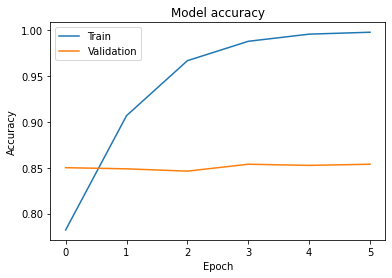

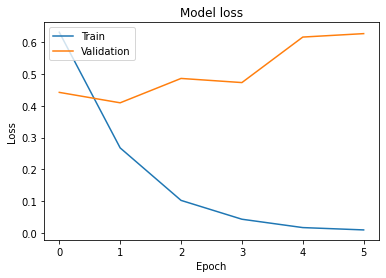

Test Loss: 0.5883594155311584 
Test Accuray: 0.8650000095367432


In [ ]:
_pre_trained_embedding = True
_train_embedding = True
# EMBEDDING_DIM = 400
# word_vectors = []

runAll( data_text, data_label, test_data_text, test_data_label,
            pre_trained_embedding = _pre_trained_embedding,
            train_embedding = _train_embedding,
            patience = 4,
            EMBEDDING_DIM = EMBEDDING_DIM,
            word_vectors = word_vectors,
            name = "Skipgram_200D", )

In [ ]:
accuracyLogsFile.close()

# CNN Codes Separately

In [ ]:
tokenizer = Tokenizer()

tokenizer.fit_on_texts(data_text)

In [ ]:
encoded_docs = tokenizer.texts_to_sequences(data_text)

In [ ]:
max_length = max([len(s.split()) for s in data_text])
Xtrain = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

In [ ]:
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
word_index = tokenizer.word_index

count = 0

embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        count += 1
        # if random.randint(0,19) == 0:
        #     print(word,"removed")
        embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25),EMBEDDING_DIM)

print(count, "many word removed.", word)

56716 many word removed. zetas


In [ ]:
del(word_vectors)

In [ ]:
train_labels = np.array( data_label.map(class_mapping) )
train_labels = to_categorical(train_labels, 5)

In [ ]:
y_test = np.array( test_data_label.map(class_mapping) )
y_test = to_categorical(y_test, 5)

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(
                                                    Xtrain,
                                                    train_labels,
                                                    test_size= 0.1,
                                                    random_state=1)

encoded_docs = tokenizer.texts_to_sequences(test_data_text)

X_test = pad_sequences(encoded_docs, maxlen=max_length, padding='post')


data_text = []
data_label = []
test_data_text = []
test_data_label = []

In [ ]:
embedding_layer = layers.Embedding(vocab_size,
                            EMBEDDING_DIM,
                            input_length=max_length,
                            weights=[embedding_matrix],
                            trainable=True,
                            input_shape=(X_train.shape[1],)
                            )

In [ ]:
EMBEDDING_DIM = 100

embedding_layer = layers.Embedding(vocab_size,
                            EMBEDDING_DIM,
                            input_length=max_length,
                            trainable=False,
                            input_shape=(X_train.shape[1],) ) 

In [ ]:
model = Sequential()

model.add(embedding_layer)

# model.add()

# model.add(layers.Conv1D(filters=128, kernel_size=2, padding="same", activation='relu'))

# model.add(layers.MaxPooling1D(pool_size=2))

# model.add(layers.Conv1D(filters=128, kernel_size=3, padding="same", activation='relu'))

# model.add(layers.MaxPooling1D(pool_size=3))

model.add(layers.Conv1D(filters=128, kernel_size=8, padding="same", activation='relu'))

model.add(layers.MaxPooling1D(pool_size=4))

model.add(layers.Flatten())

model.add(layers.Dense(128, activation='relu'))

model.add(layers.Dropout(rate=0.5))

model.add(layers.Dense(5, activation='softmax'))

# MultiChannel CNN

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data_text)

encoded_docs = tokenizer.texts_to_sequences(data_text)

max_length = max([len(s.split()) for s in data_text])
Xtrain = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

vocab_size = len(tokenizer.word_index) + 1

word_index = tokenizer.word_index

count = 0
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))

for word, i in word_index.items():
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        count += 1
        # if random.randint(0,19) == 0:
        #     print(word,"removed")
        embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25),EMBEDDING_DIM)

print("************\n", count, "many word randomized.\n************\n")

# del(word_vectors)

train_labels = np.array( data_label.map(class_mapping) )
train_labels = to_categorical(train_labels, 5)

y_test = np.array( test_data_label.map(class_mapping) )
y_test = to_categorical(y_test, 5)

X_train, X_valid, y_train, y_valid = train_test_split(
                                                Xtrain,
                                                train_labels,
                                                test_size = 0.1,
                                                random_state = 42)

encoded_docs = tokenizer.texts_to_sequences(test_data_text)

X_test = pad_sequences(encoded_docs, maxlen=max_length, padding='post')


************
 56716 many word randomized.
************



In [ ]:
length = X_train.shape[1]

In [ ]:
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.merge import concatenate

# channel 1
inputs1 = Input(shape=(length,))
embedding1 = Embedding(vocab_size,
                                EMBEDDING_DIM,
                                input_length=max_length,
                                weights=[embedding_matrix],
                                trainable=True,
                                input_shape=(X_train.shape[1],)
                                )(inputs1)
conv1 = Conv1D(filters=32, kernel_size=3, activation='relu')(embedding1)
drop1 = Dropout(0.5)(conv1)
pool1 = MaxPooling1D(pool_size=2)(drop1)
flat1 = Flatten()(pool1)
# channel 2
inputs2 = Input(shape=(length,))
embedding2 = Embedding(vocab_size,
                                EMBEDDING_DIM,
                                input_length=max_length,
                                weights=[embedding_matrix],
                                trainable=True,
                                input_shape=(X_train.shape[1],)
                                )(inputs2)
conv2 = Conv1D(filters=32, kernel_size=5, activation='relu')(embedding2)
drop2 = Dropout(0.5)(conv2)
pool2 = MaxPooling1D(pool_size=2)(drop2)
flat2 = Flatten()(pool2)
# channel 3
inputs3 = Input(shape=(length,))
embedding3 = Embedding(vocab_size,
                                EMBEDDING_DIM,
                                input_length=max_length,
                                weights=[embedding_matrix],
                                trainable=True,
                                input_shape=(X_train.shape[1],)
                                )(inputs3)
conv3 = Conv1D(filters=32, kernel_size=7, activation='relu')(embedding3)
drop3 = Dropout(0.5)(conv3)
pool3 = MaxPooling1D(pool_size=2)(drop3)
flat3 = Flatten()(pool3)
# merge
merged = concatenate([flat1, flat2, flat3])
# interpretation
dense1 = Dense(10, activation='relu')(merged)
outputs = Dense(5, activation='softmax')(dense1)
model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)

In [ ]:
es_loss = EarlyStopping(monitor='val_loss', patience=4)
es_acc = EarlyStopping(monitor='val_accuracy', patience=4)

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer = "adam",
              metrics=['accuracy'])

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 6516)]       0                                            
__________________________________________________________________________________________________
input_13 (InputLayer)           [(None, 6516)]       0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           [(None, 6516)]       0                                            
__________________________________________________________________________________________________
embedding_18 (Embedding)        (None, 6516, 200)    32745200    input_12[0][0]                   
____________________________________________________________________________________________

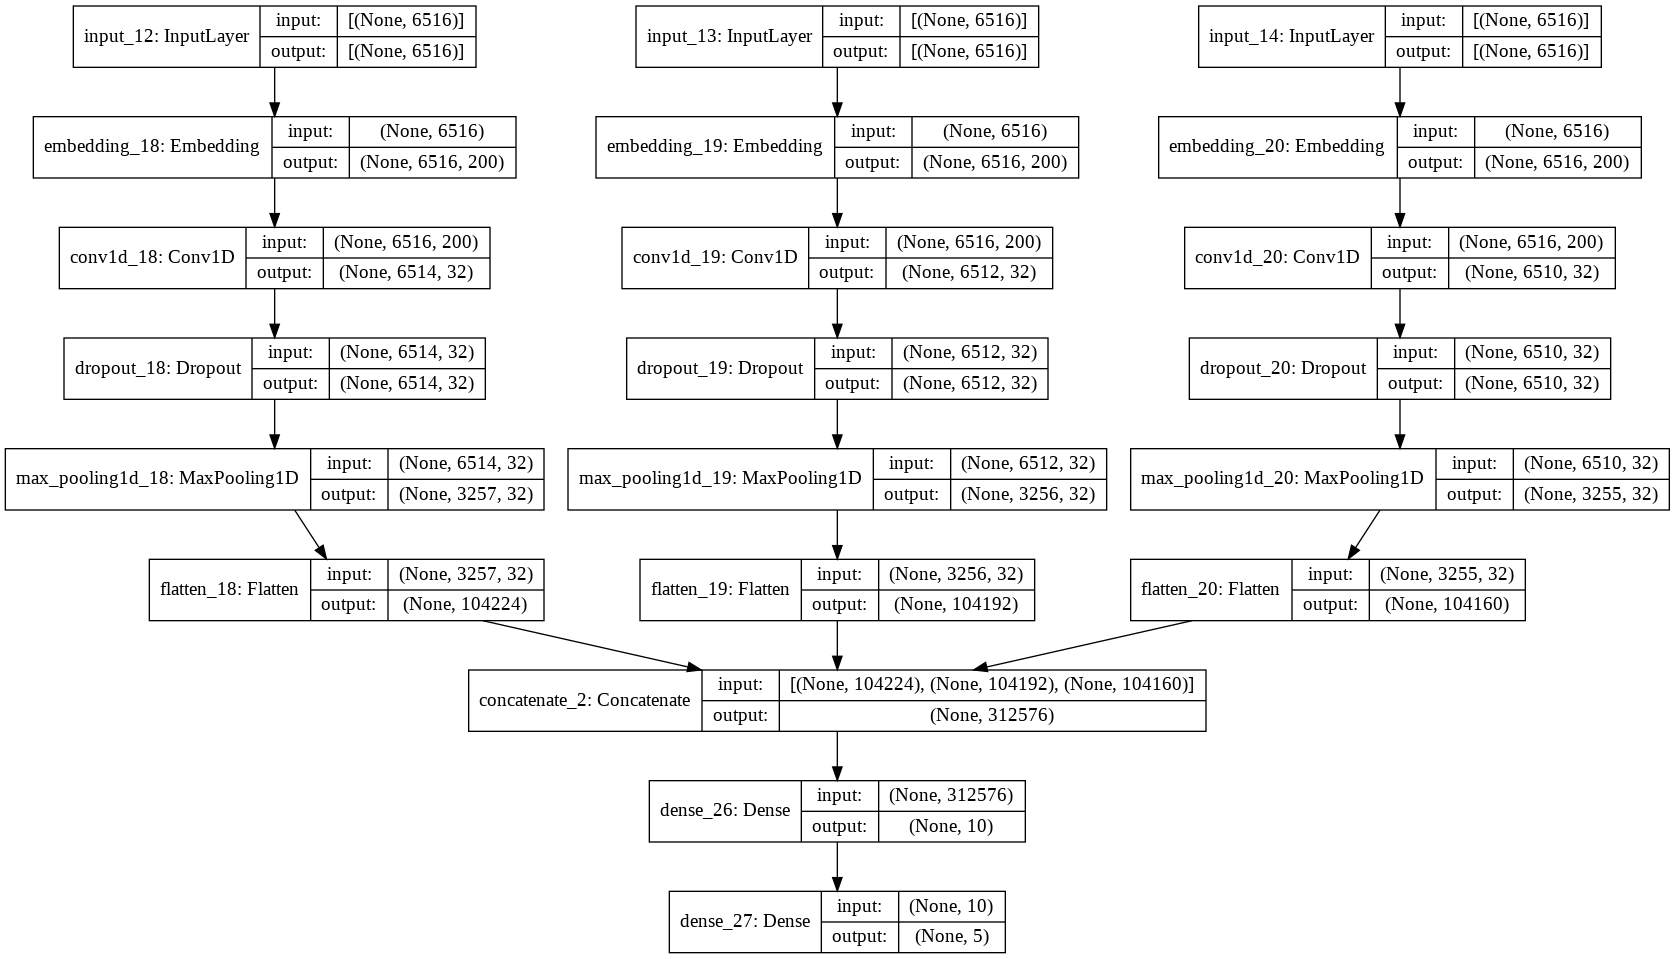

In [ ]:
plot_model(model, show_shapes=True , to_file="/content/drive/MyDrive/CS 445 Project 3/Multichannel Model Layers.png")

In [ ]:
# history = model.fit(    X_train , y_train,
#                         epochs=20,
#                         # validation_data=(X_valid, y_valid),
#                         # callbacks=[es_loss, es_acc], 
#                         verbose=1)

history = model.fit(  [X_train,X_train,X_train],
            np.array(y_train),
            epochs=10,
            validation_data=( [X_valid, X_valid, X_valid], np.array(y_valid) ),
            callbacks=[es_loss, es_acc],
            batch_size=16, )

print("DONE")

Epoch 1/10
450/450 [==============================] - 413s 916ms/step - loss: 1.1113 - accuracy: 0.5181 - val_loss: 0.7214 - val_accuracy: 0.7462
Epoch 2/10
450/450 [==============================] - 417s 928ms/step - loss: 0.3992 - accuracy: 0.8646 - val_loss: 0.5038 - val_accuracy: 0.8263
Epoch 3/10
450/450 [==============================] - 414s 921ms/step - loss: 0.1458 - accuracy: 0.9562 - val_loss: 0.5617 - val_accuracy: 0.8250
Epoch 4/10
450/450 [==============================] - 411s 913ms/step - loss: 0.0760 - accuracy: 0.9875 - val_loss: 0.6471 - val_accuracy: 0.8263
Epoch 5/10
450/450 [==============================] - 413s 917ms/step - loss: 0.0333 - accuracy: 0.9938 - val_loss: 0.7136 - val_accuracy: 0.8138
Epoch 6/10
329/450 [====================>.........] - ETA: 1:49 - loss: 0.0112 - accuracy: 0.9975

In [ ]:
plotHistory(history)

In [ ]:
loss, accuracy = model.evaluate([X_test, X_test, X_test] , np.array(y_test), verbose=False )
print("Loss:", loss, "\nAccuray:", accuracy)